In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from watertap3.truck_pipe_cost_functions import elevation,pipe_costing,truck_costing
import pprint

In [2]:
state_alpha = 'AL'

In [3]:
# Read the lcow file and the cluster lcow file

# Brackish water USGS files
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis_1.csv')
PATH = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\clustering_results\\' + state_alpha

cluster_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv').drop(['Unnamed: 0'],axis=1)

In [4]:
idx = cluster_df['cluster_lcow'].idxmin()

In [5]:
# Get individual well treatment lcow
treatment_lcow = []
well_field_yield = []
well_field_lcow = []
brine_lcow = []
treatment_lcow_no_clustering = []
brine_lcow_no_clustering = []

# Iterate through each cluster and subcluster. Create list of well unique id
for cluster in cluster_df.cluster_id.unique():
    temp_df = cluster_df[cluster_df['cluster_id']==cluster]
    # print(cluster)
    for well_id in str(temp_df['unique_site_ID'].values[0]).split(','):
        # print(well_id)
        # print(bw_df[bw_df['unique_site_ID']==well_id]['treatment_lcow'].values[0])
        treatment_lcow.append(bw_df[bw_df['unique_site_ID']==well_id]['treatment_lcow'].values[0])
        well_field_yield.append(bw_df[bw_df['unique_site_ID']==well_id]['well_yield'].values[0])
        brine_lcow.append(bw_df[bw_df['unique_site_ID']==well_id]['pipe_lcow'].values[0])
    
    well_field_lcow.append(temp_df['cluster_avg_well_field_lcow'].values[0])
    treatment_lcow_no_clustering.append(np.average(treatment_lcow, weights=well_field_yield))
    brine_lcow_no_clustering.append(np.average(brine_lcow, weights=well_field_yield))

print(treatment_lcow_no_clustering)
print(well_field_lcow)
print(brine_lcow_no_clustering)

print('Clustered LCOW')
print(cluster_df['cluster_lcow'].values)


[0.9505249421491915, 0.9424596727805266, 0.9665887142801625]
[0.0742793478891009, 0.1117712974925409, 0.0566140888089407]
[0.13237383616112303, 0.12679241851760936, 0.14098490341784065]
Clustered LCOW
[1.27608438 1.25270466 1.60117156]


Text(0.5, 1.0, 'AL')

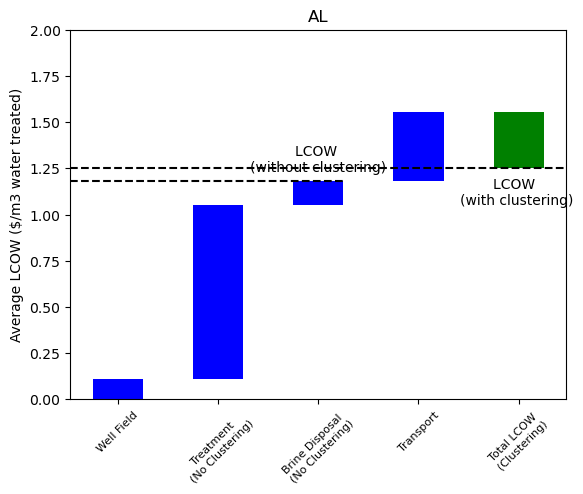

In [6]:
fig, ax = plt.subplots()

x = ['Well Field', 'Treatment \n(No Clustering)', 'Brine Disposal \n(No Clustering)', 'Transport', 'Total LCOW \n(Clustering)']

# Well Field
bottom = 0
ax.bar( x = x[0], height = well_field_lcow[idx], bottom=bottom, color='blue',width=0.5)

# Treatment
bottom = bottom + well_field_lcow[idx]             
ax.bar(x=x[1], height=treatment_lcow_no_clustering[idx], bottom = bottom, color='blue',width=0.5)
       
# Brine
bottom = bottom + treatment_lcow_no_clustering[idx]
ax.bar(x= x[2], height= brine_lcow_no_clustering[idx], bottom= bottom, color='blue',width=0.5)

# Total lcow if there was no cluster
ax.axhline(y = bottom + brine_lcow_no_clustering[idx],xmin=0, xmax=0.55, linestyle = '--',color ='black')
trans = ax.get_yaxis_transform()
plt.text(0.5,bottom + brine_lcow_no_clustering[idx]+0.05,'LCOW \n(without clustering)',
         transform=trans,horizontalalignment='center')

# Transport lcow in clustering
bottom = bottom + brine_lcow_no_clustering[idx]
ax.bar(x= x[3], height= (cluster_df['cluster_avg_pipe_well_subcluster_lcow'].values[idx] + cluster_df['cluster_avg_pipe_subcluster_cluster_lcow'].values[idx]),
            bottom = bottom, color='blue',width=0.5)

# Total LCOW in clustering
bottom = bottom + (cluster_df['cluster_avg_pipe_well_subcluster_lcow'].values[idx] + cluster_df['cluster_avg_pipe_subcluster_cluster_lcow'].values[idx])
height = min(cluster_df['cluster_lcow'].values) - bottom

ax.bar(x=x[4], height = height, bottom= bottom, color='green',width=0.5)

ax.axhline(y = cluster_df['cluster_lcow'].values[idx], linestyle = '--',color ='black')
trans = ax.get_yaxis_transform()
plt.text(0.9,cluster_df['cluster_lcow'].values[idx]-0.2,'LCOW \n(with clustering)',transform=trans,horizontalalignment='center')

ax.set_xticks(x,x,fontsize=8, rotation = 45)
ax.set_ylabel('Average LCOW ($/m3 water treated)')
ax.set_ylim([0,math.ceil(bottom)])

ax.set_title(state_alpha)

In [64]:
# Economy of scale including transport cost to the powerplant sector

In [65]:
# Trying optimization with Pyomo again
# 2 scenarios:
# 1. Total demand > BW available - Remove sum 1 constraint?
# 2. Total demand < BW available - This is straightforward

In [4]:
# Create matrix of brackish water sites (rows) and powerplant (columns) distance
from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.util.infeasible import *
from idaes.core.util.model_statistics import *

In [5]:
# Check if demand or supply is greater
# state_alpha = 'CO'
pp_combined = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power\pp_combined_unclustered_' + state_alpha.lower()+'.csv')
pp_state = pp_combined[pp_combined['State']==state_alpha]
bw_state = bw_df[bw_df['state_alpha']==state_alpha]

print('Total well yield:', bw_state['well_yield'].sum())
print('Total demand:', pp_state['PPDemand'].unique().sum())

Total well yield: 0.2883853041999994
Total demand: 324.535523644


In [6]:
# Read clustered table

pp_combined_cluster = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power\pp_combined_clustered_'+state_alpha.lower()+'.csv')
pp_state_cluster = pp_combined_cluster[pp_combined_cluster['State']==state_alpha]

PATH = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish\clustering_results\\' + state_alpha
cluster_bw_df = pd.read_csv(PATH + '\\' + state_alpha.lower()+'_cluster.csv').drop(['Unnamed: 0'],axis=1)

In [276]:
# Assuming scenario 1 where Demand < BW available
# Function for no clustering

def build_input_no_cluster(bw_state_df,pp_state_df):

    no_bw_sites = len(bw_state_df)
    no_pp_sites = len(pp_state['PPDemand'].unique())

    dist = np.zeros((no_bw_sites,no_pp_sites))
    elev_gain_mat = np.zeros((no_bw_sites,no_pp_sites))
    pp_demand = []
    # Create array with brackish water availability
    bw_vol = []
    LCOW = []
    plantcode=[]

    i = 0
    j = 0 
    for pp in pp_state_df.index.unique():
        pp_demand.append(pp_state_df['PPDemand'].loc[pp].unique()[0])
        j=0
        for site in bw_state_df.index:
            dist[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['Distance_km']
            # trans_lcow[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['TransportLCOW']
            elev_gain= pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['PPElevation'] - pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['BWElevation']
            
            if elev_gain<0:
                elev_gain = 1e-5   

            elev_gain_mat[j,i] = elev_gain

            j=j+1

        i=i+1

    for site in bw_state_df.index:
        bw_available = bw_state_df['well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
        bw_vol.append(bw_available)

        lcow = bw_state_df['lcow'].loc[site] + bw_state_df['well_field_lcow'].loc[site]/(bw_state_df['recovery'].loc[site]/100)
        
        LCOW.append(lcow)
    
    return [bw_vol,pp_demand,LCOW,elev_gain_mat,dist,bw_state_df['elec_price'].loc[site]]

def build_input_cluster(bw_state_df,pp_state_df):

    no_bw_sites = len(bw_state_df)
    no_pp_sites = len(pp_state['PPDemand'].unique())

    dist = np.zeros((no_bw_sites,no_pp_sites))
    elev_gain_mat = np.zeros((no_bw_sites,no_pp_sites))
    pp_demand = []
    # Create array with brackish water availability
    bw_vol = []
    LCOW = []
    plantcode=[]

    i = 0
    j = 0 
    for pp in pp_state_df.index.unique():
        pp_demand.append(pp_state_df['PPDemand'].loc[pp].unique()[0])
        j=0
        for site in bw_state_df.index:
            dist[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['Distance_km']
            # trans_lcow[j,i] = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['TransportLCOW']
            elev_gain = pp_state_df[(pp_state_df['BWSites']==site)].loc[pp]['PPElevation'] - bw_state_df['centroid_elev'].loc[site]

            if elev_gain<0:
                elev_gain = 1e-5   

            elev_gain_mat[j,i] = elev_gain
            
            j=j+1

        i=i+1

    for site in bw_state_df.index:
        bw_available = bw_state_df['cluster_total_well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
        bw_vol.append(bw_available)

        lcow = bw_state_df['cluster_lcow'].loc[site]
        
        LCOW.append(lcow)
    
    return [bw_vol,pp_demand,LCOW,elev_gain_mat,dist,bw_state_df['elec_price'].loc[site]]


def try_cool_matrix(bw_vol,demand,lcow,elev_gain,dist,elec_rate):

    m = ConcreteModel()
    m.I = pyo.Set(initialize = range(dist.shape[0]))
    # powerplant site index
    m.J = pyo.Set(initialize = range(dist.shape[1]))

    m.matrix= pyo.Set(initialize = m.I*m.J)
    m.x = Var(m.matrix, domain=NonNegativeReals, bounds= (0,1), initialize = 1/(dist.shape[0]*dist.shape[1]))

    m.constraints= pyo.ConstraintList()

    # Sum of fractions should be less than or equal to 1
    for i in m.I:
        m.constraints.add((sum(m.x[i,j] for j in m.J)) <= 1 )
    
    # Production to be as close to maximum as possible
    for j in m.J:
       m.constraints.add((sum((m.x[i,j]*float(bw_vol[i])) for i in m.I)) == float(demand[j]))

    # for j in m.J:
    #     m.constraints.add((sum(( LCOW[i]*m.x[i,j] + transport_cost(bw_vol[i],dist[i,j])*m.x[i,j] ) for i in m.I)) <= 2)

    # def obj_demand(m):
    #     return sum(sum(m.x[i,j]*float(bw_vol[i]) for i in m.I) for j in m.J)
    

    # LCOW objective
    def obj(m):
        m.total_supply = sum(sum((bw_vol[i]*m.x[i,j]) for i in m.I) for j in m.J)

        m.treatment_lcow =  sum(sum(bw_vol[i]*lcow[i]*m.x[i,j] for i in m.I) for j in m.J)/m.total_supply

        # supply = m.x
        # for i in m.I:
        #     for j in m.J:
        #         supply[i,j] = bw_vol[i]*m.x[i,j]

        m.transport_lcow =  sum(sum((bw_vol[i]*m.x[i,j]*pipe_costing(bw_vol[i]*m.x[i,j]*3600*24,
                                                                   dist[i,j],
                                                                   elev_gain = elev_gain[i,j],
                                                                   electricity_rate=elec_rate)) for i in m.I) for j in m.J)/m.total_supply
                              
        return m.treatment_lcow + m.transport_lcow
    
    # m.obj2 = Objective(rule=obj_demand,sense = pyo.maximize)
    m.obj1 = Objective(rule = obj)

    solver = SolverFactory('ipopt')
    results = solver.solve(m)

    return m

def opt_check_cluster(bw_state,pp_state,cluster = 0):
    if cluster == 0:
        bw_state_df = bw_state.set_index('unique_site_ID')
        pp_state_df = pp_state.set_index('PlantCode')
        [bw_vol,pp_demand,LCOW,elev_gain,dist,elec_rate] = build_input_no_cluster(bw_state_df,pp_state_df)
    
    else:
        bw_state_df = bw_state.set_index('cluster_id')
        pp_state_df = pp_state.set_index('PlantCode')
        [bw_vol,pp_demand,LCOW,elev_gain,dist,elec_rate] = build_input_cluster(bw_state_df,pp_state_df)
    
    solver = SolverFactory('ipopt')
    
    m = try_cool_matrix(bw_vol,pp_demand,LCOW,elev_gain,dist,elec_rate)
    print('Treatment LCOW:',m.treatment_lcow())
    print('Transport LCOW:',m.transport_lcow())
    print('LCOW:',m.obj1())
    dict = (m.x.get_values())

    x = np.zeros(dist.shape)

    for i,j in dict.keys():
        if dict[(i,j)] < 1e-5:
            x[i,j] = 0
        else:
            x[i,j] = dict[(i,j)]

    supply = (np.array(x).T * np.array(bw_vol))

    results = pd.DataFrame(supply,columns=bw_state_df.index.unique(),index=pp_state_df.index.unique())

    return [m,results,x,bw_vol,supply,LCOW,elev_gain,dist,elec_rate]


In [277]:
m,results,x,bw_vol,supply,lcow,elev_gain,dist,elec_rate = opt_check_cluster(bw_state,pp_state,cluster=0)

print(m.obj1())

Treatment LCOW: 0.8238510614026611
Transport LCOW: 335.44512896148194
LCOW: 336.2689800228846
336.2689800228846


In [278]:
I = len(bw_state)
J = len(pp_state['PlantCode'].unique())

total_supply = sum(sum((bw_vol[i]*x[i,j]) for i in range(I)) for j in range(J))

treatment_cost = sum(sum((bw_vol[i]*lcow[i]*x[i,j]) for i in range(I)) for j in range(J))/total_supply
# transport_cost = sum(sum((bw_vol[i]*trans_lcow[i,j]*x[i,j]) for i in range(I)) for j in range(J))/total_supply
transport_cost = sum(sum((bw_vol[i]*x[i,j]*pipe_costing(bw_vol[i]*3600*24,
                                                                   dist[i,j],
                                                                   elev_gain = elev_gain[i,j],
                                                                   electricity_rate=elec_rate)) for i in range(I)) for j in range(J))/total_supply

transport_cost2 = sum(sum((bw_vol[i]*x[i,j]*pipe_costing(bw_vol[i]*x[i,j]*3600*24,
                                                                   dist[i,j],
                                                                   elev_gain = elev_gain[i,j],
                                                                   electricity_rate = elec_rate)) for i in range(I)) for j in range(J))/total_supply
print('Total supply:',total_supply)
print('Treatment LCOW:',treatment_cost)
print('Transport LCOW:',transport_cost)
print('LCOW:', treatment_cost+transport_cost)
print('Transport LCOW 2:',transport_cost2)
print('LCOW:', treatment_cost+transport_cost2)

Total supply: 1.890229771353574
Treatment LCOW: 0.8238509730514063
Transport LCOW: 1.0732754278236945
LCOW: 1.8971264008751008
Transport LCOW 2: 1.156771362458339
LCOW: 1.9806223355097452


In [275]:
# results.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power\optimization_attempt\\'+
#                state_alpha.lower() +'_no_clustering_v3.csv')

In [261]:
m,results,x,bw_vol,supply,lcow,elev_gain,dist,elec_rate = opt_check_cluster(cluster_bw_df,pp_state_cluster,cluster=1)

Treatment LCOW: 0.9597760596482053
Transport LCOW: 2.148347560685811
LCOW: 3.108123620334016


In [262]:
I = len(cluster_bw_df)
J = len(pp_state_cluster['PlantCode'].unique())

total_supply = sum(sum((bw_vol[i]*x[i,j]) for i in range(I)) for j in range(J))

treatment_cost = sum(sum((bw_vol[i]*lcow[i]*x[i,j]) for i in range(I)) for j in range(J))/total_supply
# transport_cost = sum(sum((bw_vol[i]*trans_lcow[i,j]*x[i,j]) for i in range(I)) for j in range(J))/total_supply
transport_cost = sum(sum((bw_vol[i]*x[i,j]*pipe_costing(bw_vol[i]*x[i,j]*3600*24,
                                                                   dist[i,j],
                                                                   elev_gain = elev_gain[i,j],
                                                                   electricity_rate=elec_rate)) for i in range(I)) for j in range(J))/total_supply
print('Total supply:',total_supply)
print('Treatment LCOW:',treatment_cost)
print('Transport LCOW:',transport_cost)
print('LCOW:', treatment_cost+transport_cost)


Total supply: 1.8902320810553974
Treatment LCOW: 0.9597760588007468
Transport LCOW: 0.5796461257451146
LCOW: 1.5394221845458613


In [257]:
# results.to_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Power\optimization_attempt\\'+
#                state_alpha.lower() +'_clustering_v2.csv')

In [7]:
# Assuming scenario 2 where demand > supply
# Sort the list use minimum tLCOW connections. Track well volume 

# Create dictionary of wells
well_site  = pp_state['BWSites'].unique()
well_vol = (pp_state[pp_state['BWSites']==well]['BWAvailable'].unique()[0] for well in well_site)
wells_unclustered = dict(zip(well_site,well_vol))

# Create dictionary of powerplants
pp_pc = pp_state['PlantCode'].unique()
pp_demand = (pp_state[pp_state['PlantCode']==pp]['PPDemand'].unique()[0] for pp in pp_pc)
pp_unclustered = dict(zip(pp_pc,pp_demand))

# Sort the datafram in increasing order of tLCOW
pp_state_sorted = pp_state.sort_values(['tLCOW'],ignore_index=True)
optimize_network = pd.DataFrame(columns = pp_state.columns.values)

for idx,row in pp_state_sorted.iterrows():
    # Check if demand has already been met and if well is already exhausted
    if wells_unclustered[row['BWSites']]>0:
        if pp_unclustered[row['PlantCode']]>0:
            optimize_network.loc[len(optimize_network)] = row
            # Update demand and well availability
            temp =  pp_unclustered[row['PlantCode']]
            pp_unclustered[row['PlantCode']] = pp_unclustered[row['PlantCode']] -  wells_unclustered[row['BWSites']]
            wells_unclustered[row['BWSites']] = wells_unclustered[row['BWSites']] - pp_unclustered[row['PlantCode']]

optimize_network1 = optimize_network.sort_values(['PlantCode','tLCOW']).groupby('PlantCode')
optimize_network1 = optimize_network1.apply(pd.DataFrame).set_index('PlantCode')

weighted_lcow = []
cum_pp_demand_frac_met = []
cum_bw_vol = []

for pp in optimize_network1.index.unique():
    try:
        cum_bw_available = np.array(optimize_network1['BWAvailable'].loc[pp].cumsum())
        cum_cost = np.array((optimize_network1['BWAvailable'].loc[pp]*optimize_network1['tLCOW'].loc[pp]).cumsum())
    except AttributeError:
        cum_bw_available =  np.array([optimize_network1['BWAvailable'].loc[pp]])
        cum_cost = np.array((optimize_network1['BWAvailable'].loc[pp]*optimize_network1['tLCOW'].loc[pp]))

    temp = np.divide(cum_cost,cum_bw_available)
    cum_bw_vol=np.append(cum_bw_vol,cum_bw_available)
    weighted_lcow = np.append(weighted_lcow,temp,axis=0)
    temp_demand_met = cum_bw_available/optimize_network1['PPDemand'].loc[pp]
    cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

optimize_network1['WeightedtLCOW'] = weighted_lcow
optimize_network1['Cum_Vol'] = cum_bw_vol
optimize_network1['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
optimize_network1['Cum_PPDemandFracMet'] = np.where(optimize_network1['Cum_PPDemandFracMet']>1,1,optimize_network1['Cum_PPDemandFracMet'])     

optimize_network_unclustered = optimize_network1
optimize_network_unclustered

c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,State,PPLatitude,PPLongitude,PPDemand,BWSites,BWLatitude,BWLongitude,BWAvailable,Distance_km,PPDemandFracMet,LCOW,TransportLCOW,tLCOW,WeightedtLCOW,Cum_PPDemandFracMet,PPElevation,BWElevation,Cum_Vol
PlantCode,,,,,,,,,,,,,,,,,,
3,AL,31.0069,-88.0103,57.648886,FETH-304300N0880100.1,30.716667,-88.016694,0.016167,32.278286,0.00028,1.439345,0.820987,2.260332,2.260332,0.00028,6.572838,0.572287,0.016167
3,AL,31.0069,-88.0103,57.648886,USGS-301514088071701,30.254093,-88.121391,0.01356,84.38054,0.000235,1.508361,2.16158,3.669941,2.903337,0.000516,6.572838,0.922551,0.029727
10,AL,32.6017,-87.7811,32.119974,USGS-323012087492701,32.503471,-87.824181,0.032926,11.644975,0.001025,1.168814,0.249207,1.418021,1.418021,0.001025,31.777483,48.823505,0.032926
10,AL,32.6017,-87.7811,32.119974,FETH-320300N0873200.1,32.05,-87.533361,0.016246,65.61426,0.000506,1.492627,1.532787,3.025414,1.949092,0.001531,31.777483,43.870712,0.049172
56,AL,31.48802,-87.9107,0.299901,USGS-315412087443401,31.902098,-87.742783,0.016139,48.707128,0.053816,1.509004,1.160651,2.669655,2.669655,0.053816,0.0,112.382591,0.016139
533,AL,31.40026,-86.4764,0.166917,USGS-311930086272501,31.32517,-86.456902,0.044227,8.552368,0.264964,1.098779,0.178096,1.276875,1.276875,0.264964,74.249077,104.84388,0.044227
533,AL,31.40026,-86.4764,0.166917,USGS-310153085514501,31.031568,-85.862434,0.029304,71.341448,0.175558,1.226884,1.187307,2.414191,1.730122,0.440523,74.249077,28.621227,0.073531
6002,AL,33.6319,-87.0597,1.77714,FETH-333800N0865900.1,33.633333,-86.983361,0.039767,7.069382,0.022377,1.065072,0.168826,1.233898,1.233898,0.022377,92.802856,135.401932,0.039767
6002,AL,33.6319,-87.0597,1.77714,FETH-332800N0865900.1,33.466667,-86.983361,0.056949,19.688047,0.032045,1.025663,0.274092,1.299755,1.272677,0.054422,92.802856,185.24765,0.096716


In [25]:
2.903337*0.029727 + 1.949092*0.049172 + 2.669655*0.016139 + 1.730122*0.073531 + 1.272677*0.096716

0.47553964238199997

In [24]:
# Calculate weight tLCOW for the state for unclustered scenario

lcow_uncluster = 0 
vol = 0
temp = 0 

for pp in optimize_network_unclustered.index.unique():
    try:
        temp = temp + optimize_network_unclustered.loc[pp]['WeightedtLCOW'].values[-1]*optimize_network_unclustered.loc[pp]['Cum_Vol'].values[-1]
        vol = vol + optimize_network_unclustered.loc[pp]['Cum_Vol'].values[-1]
    except:
        temp = temp + optimize_network_unclustered.loc[pp]['WeightedtLCOW']*optimize_network_unclustered.loc[pp]['Cum_Vol']
        vol = vol + optimize_network_unclustered.loc[pp]['Cum_Vol']


lcow_uncluster = temp/vol
lcow_uncluster

print(temp)



0.4755388942300645


In [10]:
transport_lcow_unclustered = 0
treatment_lcow_unclustered = 0
vol = 0
temp = 0 

for idx,row in optimize_network_unclustered.iterrows():
    transport_lcow_unclustered = transport_lcow_unclustered + row['BWAvailable']*row['TransportLCOW']
    treatment_lcow_unclustered = treatment_lcow_unclustered + row['BWAvailable']*row['LCOW']

    vol = vol + row['BWAvailable']

transport_lcow_unclustered = transport_lcow_unclustered/vol
treatment_lcow_unclustered = treatment_lcow_unclustered/vol    

print('Transport:',transport_lcow_unclustered)
print('Treatment:',treatment_lcow_unclustered)

Transport: 0.6009223999504631
Treatment: 1.1916404988178873


In [17]:
# For clustered dataframe

# Create dictionary of clusters
well_site  = pp_state_cluster['BWSites'].unique()
well_vol = (pp_state_cluster[pp_state_cluster['BWSites']==well]['BWAvailable'].unique()[0] for well in well_site)
wells_clustered = dict(zip(well_site,well_vol))

# Create dictionary of powerplants
pp_pc = pp_state_cluster['PlantCode'].unique()
pp_demand = (pp_state_cluster[pp_state_cluster['PlantCode']==pp]['PPDemand'].unique()[0] for pp in pp_pc)
pp_clustered = dict(zip(pp_pc,pp_demand))

# pp_clustered
# Sort the datafram in increasing order of tLCOW
pp_state_cluster_sorted = pp_state_cluster.sort_values(['tLCOW'],ignore_index=True)
optimize_network = pd.DataFrame(columns = pp_state_cluster.columns.values)

for idx,row in pp_state_cluster_sorted.iterrows():
    # Check if demand has already been met and if well is already exhausted
    if wells_clustered[row['BWSites']]>0:
        if pp_clustered[row['PlantCode']]>0:
            optimize_network.loc[len(optimize_network)] = row
            # Update demand and well availability
            temp =  pp_clustered[row['PlantCode']]
            pp_clustered[row['PlantCode']] = pp_clustered[row['PlantCode']] -  wells_clustered[row['BWSites']]
            wells_clustered[row['BWSites']] = wells_clustered[row['BWSites']] - pp_clustered[row['PlantCode']]

optimize_network1 = optimize_network.sort_values(['PlantCode','tLCOW']).groupby('PlantCode')
optimize_network1 = optimize_network1.apply(pd.DataFrame).set_index('PlantCode')
# optimize_network1

weighted_lcow = []
cum_pp_demand_frac_met = []
cum_bw_vol = []

for pp in optimize_network1.index.unique():
    try:
        cum_bw_available = np.array(optimize_network1['BWAvailable'].loc[pp].cumsum())
        cum_cost = np.array((optimize_network1['BWAvailable'].loc[pp]*optimize_network1['tLCOW'].loc[pp]).cumsum())
    except AttributeError:
        cum_bw_available =  np.array([optimize_network1['BWAvailable'].loc[pp]])
        cum_cost = np.array((optimize_network1['BWAvailable'].loc[pp]*optimize_network1['tLCOW'].loc[pp]))

    temp = np.divide(cum_cost,cum_bw_available)
    cum_bw_vol=np.append(cum_bw_vol,cum_bw_available)
    weighted_lcow = np.append(weighted_lcow, temp,axis=0)
    temp_demand_met = cum_bw_available/optimize_network1['PPDemand'].loc[pp]
    cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

optimize_network1['WeightedtLCOW'] = weighted_lcow
optimize_network1['Cum_Vol'] = cum_bw_vol
optimize_network1['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
optimize_network1['Cum_PPDemandFracMet'] = np.where(optimize_network1['Cum_PPDemandFracMet']>1,1,optimize_network1['Cum_PPDemandFracMet'])     

optimize_network_clustered = optimize_network1
optimize_network_clustered

c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,State,PPLatitude,PPLongitude,PPDemand,BWSites,BWLatitude,BWLongitude,BWAvailable,Distance_km,PPDemandFracMet,LCOW,TransportLCOW,tLCOW,WeightedtLCOW,Cum_PPDemandFracMet,PPElevation,BWElevation,Cum_Vol
PlantCode,,,,,,,,,,,,,,,,,,
3,AL,31.0069,-88.0103,57.648886,2,30.716667,-88.016694,0.029616,32.278286,0.000514,1.276084,0.568222,1.844307,1.844307,0.000514,6.572838,0.572287,0.029616
10,AL,32.6017,-87.7811,32.119974,0,32.503471,-87.824181,0.160414,11.644975,0.004994,1.276084,0.122411,1.398495,1.398495,0.004994,31.777483,48.823505,0.160414
533,AL,31.40026,-86.4764,0.166917,1,31.32517,-86.456902,0.073298,8.552368,0.43913,1.276084,0.141442,1.417526,1.417526,0.439130,74.249077,104.84388,0.073298


In [18]:
# Calculate weight tLCOW for the state for clustered scenario

lcow_cluster = 0 
vol = 0
temp = 0 

for pp in optimize_network_clustered.index.unique():
    try:
        temp = temp + optimize_network_clustered.loc[pp]['WeightedtLCOW'].values[-1]*optimize_network_clustered.loc[pp]['Cum_Vol'].values[-1]
        vol = vol + optimize_network_clustered.loc[pp]['Cum_Vol'].values[-1]
    except:
        temp = temp + optimize_network_clustered.loc[pp]['WeightedtLCOW']*optimize_network_clustered.loc[pp]['Cum_Vol']
        vol = vol + optimize_network_clustered.loc[pp]['Cum_Vol']


lcow_uncluster = temp/vol
lcow_uncluster

1.4539322950555935

In [19]:
transport_lcow_unclustered = 0
treatment_lcow_unclustered = 0
vol = 0
temp = 0 

for idx,row in optimize_network_clustered.iterrows():
    transport_lcow_unclustered = transport_lcow_unclustered + row['BWAvailable']*row['TransportLCOW']
    treatment_lcow_unclustered = treatment_lcow_unclustered + row['BWAvailable']*row['LCOW']

    vol = vol + row['BWAvailable']

transport_lcow_unclustered = transport_lcow_unclustered/vol
treatment_lcow_unclustered = treatment_lcow_unclustered/vol    

print('Transport:',transport_lcow_unclustered)
print('Treatment:',treatment_lcow_unclustered)

Transport: 0.17784791344641457
Treatment: 1.276084382
